In [19]:
from math import sqrt, exp, log, floor
from random import gauss, randint, random
from copy import deepcopy, copy
import numpy as np

class Subsystem:
    def __init__(self, index):
        self.index = index
        self.__init_params()
    
    def __init_params(self):
        self.beta = 1.5
        self.t1 = 1 / sqrt(2 * 5)
        self.t2 = 1 / sqrt( 2 * sqrt(5))
        self.n = randint(1, 5) # generate random integer for n_i
        self.r = random()       # generate random float between 0 and 1 for r_i
        self.sigma = 1          # generate random value for sigma
        self.sigman = 1
        self.r_mutation_rate = 90
        self.n_mutation_rate = 70
        
        if self.index == 0:
            self.alpha = 2.330E-5
            self.wv2 = 1
            self.w = 7
        elif self.index == 1:
            self.alpha = 1.450E-5
            self.wv2 = 2
            self.w = 8
        elif self.index == 2:
            self.alpha = 0.541E-5
            self.wv2 = 3
            self.w = 8
        elif self.index == 3:
            self.alpha = 8.050E-5
            self.wv2 = 4
            self.w = 6
        elif self.index == 4:
            self.alpha = 1.950E-5
            self.wv2 = 2
            self.w = 9
            
    def update(self, random_num):
        '''Mutate r_i'''
        if randint(0,100) < self.r_mutation_rate:
            power =  (self.t1 * random_num) + (self.t2 * gauss(0, 1))
            new_sigma = self.sigma * exp(power)
            # A boundary rule is applied to prevent standard deviations very close to zero.
            new_sigma = new_sigma if new_sigma > 0.1E-4 else 0.1E-4
            new_r = self.r + (new_sigma * gauss(0, 1))
            if new_r >= 0 and new_r <= 1:
                self.r = new_r
                self.sigma = new_sigma
        '''Mutate n_i'''
        if randint(0,100) < self.n_mutation_rate:
            power =  (self.t1 * random_num) + (self.t2 * gauss(0, 1))
            new_sigman = self.sigman * exp(power)
            new_sigman = new_sigman if new_sigman > 0.1E-4 else 0.1E-4
            new_n = self.n + floor(new_sigman * gauss(0, 1))
            if new_n > 0:
                self.n = new_n
                self.sigman = new_sigman
#             if randint(0,1) == 0:
#                 if self.n - 1 > 0:
#                     self.n -= 1
#             else:
#                 self.n += 1

class System():
    
    def  __init__(self):
        self.subsystems = []
        self.V = 110
        self.W = 200
        self.C = 175
        self.num = 5 # Number of subsystems
        self.__create_subsystems()
    
    def __create_subsystems(self):
        for i in range(self.num):
            self.subsystems.append(Subsystem(i))
    
    def update(self):
        random_num = gauss(0, 1)
        for i in range(len(self.subsystems)):
            self.subsystems[i].update(random_num)

            
def g1(system):
    res = 0
    for subsys in system.subsystems:
        res += subsys.wv2 * (subsys.n ** 2)
    return res - system.V <= 0

def g2(system):
    res = 0
    for subsys in system.subsystems:
        temp = subsys.alpha * ((-1000 / log(subsys.r)) ** subsys.beta)
        res += temp * subsys.n + exp(0.25 * subsys.n)
    return res - system.C <= 0

def g3(system):
    res = 0
    for subsys in system.subsystems:
        res += subsys.w * subsys.n * exp(0.25 * subsys.n)
    return res - system.W <= 0

def subsys_reliability(system):
    R = []
    for subsys in system.subsystems:
        temp = 1 - ((1 - subsys.r) ** subsys.n)
        R.append(temp)
    return R

def fitness_func_complex(system):
    if g1(system) and g2(system) and g3(system):
        R = subsys_reliability(system)
        fitness = ((R[0]*R[1]) + (R[2]*R[3]) + (R[0]*R[3]*R[4])+
                    (R[1]*R[2]*R[4]) - (R[0]*R[1]*R[2]*R[3]) - (R[0]*R[1]*R[2]*R[4])-
                    (R[0]*R[1]*R[3]*R[4]) - (R[0]*R[2]*R[3]*R[4]) - (R[1]*R[2]*R[3]*R[4])+
                    (2*R[0]*R[1]*R[2]*R[3]*R[4]))
        return fitness
    else:
        return 0

def fitness_func_series(system):
    if g1(system) and g2(system) and g3(system):
        R = subsys_reliability(system)
        fitness = 1
        for r in R:
            fitness *= r
        return fitness
    else:
        return 0


def init_population(size):
    population = []
    while len(population) < size:
        system = System()
        if g1(system) and g2(system) and g3(system):
            population.append(system)
        else:
            continue
    return population

def select(population):
    index = randint(0, len(population) - 1)
    return deepcopy(population[index])

def generate_childs(population, size):
    childs = []
    while len(childs) < size:
        system = select(population)
        system.update()
        childs.append(system)
    return childs

def fit_complex(population):
    epochs = 200
    size = len(population) * 7
    for i in range(epochs):
        childs = generate_childs(population, size)
        childs_fitness = list(map(fitness_func_complex, childs))
        sorted_indexes = np.array(childs_fitness).argsort()[::-1]
        mean_fit_log.append(np.mean(np.array(childs_fitness)[sorted_indexes[:len(population)]]))
        best_fit_log.append(childs_fitness[sorted_indexes[0]])
        population = np.array(childs)[sorted_indexes[:len(population)]]
        


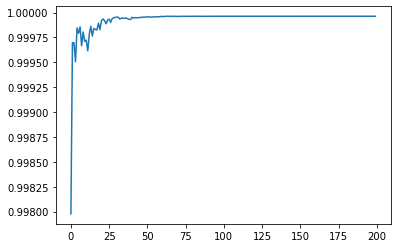

In [8]:
best_fit_log = []
mean_fit_log =[]
population = init_population(100)
fit_complex(population)


import matplotlib.pyplot as plt
plt.plot(list(range(len(best_fit_log))), best_fit_log)
plt.show()

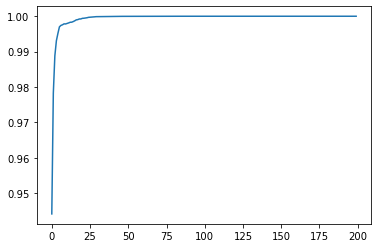

In [9]:
plt.plot(list(range(len(mean_fit_log))), mean_fit_log)
plt.show()

In [38]:
def fit_series(population):
    epochs = 200
    size = len(population) * 7
    for i in range(epochs):
        childs = generate_childs(population, size)
        childs_fitness = list(map(fitness_func_series, childs))
        sorted_indexes = np.array(childs_fitness).argsort()[::-1]
        mean_fit_log.append(np.mean(np.array(childs_fitness)[sorted_indexes[:len(population)]]))
        best_fit_log.append(childs_fitness[sorted_indexes[0]])
        population = np.array(childs)[sorted_indexes[:len(population)]]
        
best_fit_log = []
mean_fit_log =[]
population = init_population(100)
fit_series(population)

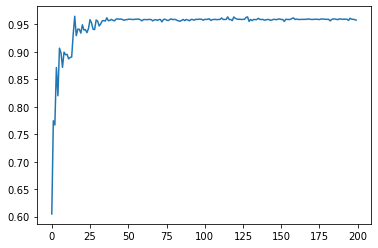

In [39]:
import matplotlib.pyplot as plt
plt.plot(list(range(len(best_fit_log))), best_fit_log)
plt.show()

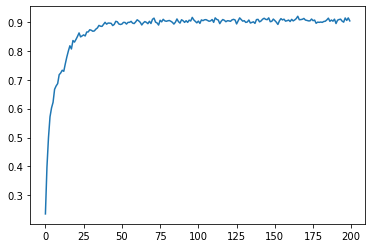

In [40]:
plt.plot(list(range(len(mean_fit_log))), mean_fit_log)
plt.show()